In [25]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

from dataloader import FastTensorDataLoader

In [29]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Generation

In [2]:
def generate_samples(mean, cov_or_std, d, m, n):
    """
    Generate a list of samples drawn from a normal distribution (1D or multivariate).

    Args:
        mean (torch.Tensor or float): Mean of the normal distribution.
            - For d > 1: A tensor of shape (d,).
            - For d = 1: A scalar.
        cov_or_std (torch.Tensor or float): Covariance matrix or standard deviation.
            - For d > 1: A tensor of shape (d, d) (covariance matrix).
            - For d = 1: A scalar (standard deviation).
        d (int): Number of dimensions for each sample.
        m (int): Number of samples to generate.
        n (int): Number of elements in each sample.

    Returns:
        list[torch.Tensor]: A list of `m` tensors.
            - For d > 1: Each tensor has shape (n, d).
            - For d = 1: Each tensor has shape (n, 1).
    """
    samples = []
    if d == 1:
        # Univariate case
        if not isinstance(mean, (float, int)) or not isinstance(cov_or_std, (float, int)):
            raise ValueError("For d=1, 'mean' and 'cov_or_std' must be scalars.")
        for _ in range(m):
            sample = torch.normal(mean=mean, std=cov_or_std, size=(n,))
            sample = sample.unsqueeze(-1) 
            samples.append(sample.clone())
    else:
        # Multivariate case
        if mean.shape[0] != d or cov_or_std.shape != (d, d):
            raise ValueError("For d > 1, 'mean' must have shape (d,) and 'cov_or_std' must have shape (d, d).")
        distribution = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov_or_std)
        for _ in range(m):
            sample = distribution.sample((n,))  # Generate n samples for each tensor
            samples.append(sample.clone())
    
    return samples


### Normal Gaussian

In [3]:
mean, std = 0, 2
m, n = 100, 1000
samples = generate_samples(mean, std, 1, m, n)
X = torch.stack(samples, dim=0)

### Multivariate Gaussian

In [33]:
mu = torch.tensor([0.0, 0.0])
cov = torch.tensor([[1.0, 0], [0, 1.0]])
m, n = 100, 1000
samples = generate_samples(mu, cov, 2, m, n)

X = torch.stack(samples, dim=0)

### Data Loader

In [34]:
# Split the data into train, validation, and test sets
train_size = int(0.8 * len(X))

X_train = X[:train_size]
X_test = X[train_size:]

# Load the filtered data into FastTensorDataLoader
loader_train = FastTensorDataLoader(X_train, batch_size=32, shuffle=False)
loader_test = FastTensorDataLoader(X_test, batch_size=32, shuffle=False)

# Print to confirm
print(f"Filtered Samples Shape: {len(samples)}")
print(f"Train Loader Batches: {len(loader_train)}, Test Loader Batches: {len(loader_test)}")


Filtered Samples Shape: 100
Train Loader Batches: 3, Test Loader Batches: 1


## Neural Network

In [35]:
class Gaussian_NN(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=32, output_dim=1):
        super().__init__()
        torch.manual_seed(123)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_dim = input_dim  # Initially None, determined dynamically
        
        # Placeholders for layers; they will be initialized once input_dim is set
        self.fc1 = None
        self.fc2 = None

    def initialize_layers(self, input_dim):
        """Initialize layers based on input_dim."""
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        if self.fc1 is None or self.fc2 is None:
            self.initialize_layers(x.shape[-1])

        x = torch.tanh(self.fc1(x))
        intensity = torch.nn.functional.softplus(self.fc2(x))
        return intensity
    
    def compute_psi(self, x):
        x = x.float()
        x.requires_grad_()
        nn_output = torch.log(self.forward(x))
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi

    def loss(self, x_t):
        lengths = len(x_t)
        if not isinstance(x_t, torch.Tensor):
            x_t = torch.tensor(x_t, dtype=torch.float32)
        x_t  = x_t.clone().detach().requires_grad_(True)
        psi_x = self.compute_psi(x_t)
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        divergence = 0
        for i in range(x_t.shape[-1]):  
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/lengths

        batch_size = x_t.size(0)
        total_loss = total_loss.mean() / batch_size
        
        return total_loss.mean()


In [36]:
def optimize_nn(
        loader_train, nn_model, num_epochs=1000, learning_rate=1e-3, grad_clip_value=1.0):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.
        patience (int): Number of epochs to wait before early stopping.

    Returns:
        tuple: (trained model, train_losses)
    """
    def initialize_model_and_optimizer():
        model = nn_model()
        sample_input = next(iter(loader_train))[0].float() # without length dimension
        model(sample_input)  # Forward pass to initialize the layers
        optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
        return model, optimizer

    def run_epoch(loader, model, optimizer=None, total_samples=None):
        mode = model.train
        mode()

        loss_sum = 0.0
        for X_batch in loader:
            x_data = X_batch[0]
            
            optimizer.zero_grad()
            loss = model.loss(x_data)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_value)
            optimizer.step()

            loss_sum += loss.item() 

        return loss_sum / total_samples if total_samples > 0 else 0.0


    model, optimizer = initialize_model_and_optimizer()
    train_losses = []
    train_samples = len(loader_train)

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    for _ in pbar:
        start_time = time.time()

        # Training phase
        avg_train_loss = run_epoch(loader_train, model, optimizer, total_samples=train_samples)
        train_losses.append(avg_train_loss)

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{avg_train_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })

    return model, train_losses

In [37]:
epochs = 100
model, train_losses = optimize_nn(
    loader_train, Gaussian_NN, num_epochs=epochs, learning_rate=1e-3,
)

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training: 100%|██████████| 100/100 [00:30<00:00,  3.31epoch/s, Train Loss=-1.9097, Time/Epoch=0.29s]


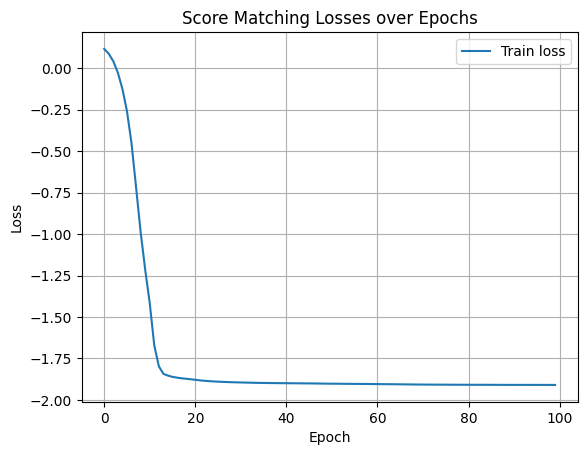

In [38]:
plt.plot(train_losses, label="Train loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Score Matching Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Predicted Intensity vs True Intensity 1d

In [39]:
# Extract the 1D data
x = X_test[0]

# Compute range for the 1D data
x_min, x_max = x.min(), x.max()

# Generate a 1D grid for intensity
x_lin = np.linspace(x_min, x_max, 100)  # Adjust resolution if needed

# Compute predicted intensity values for the grid
intensity_pred = model(torch.tensor(x_lin[:, None], dtype=torch.float32)).squeeze().detach().numpy()

# Compute true intensity values for the grid (assuming Gaussian distribution)
mu_x = mean  # Mean of the Gaussian in 1D
sigma_x = np.sqrt(std**2)  # Standard deviation
lambda_0 = 1 / (np.sqrt(2 * np.pi) * sigma_x)
intensity_real = lambda_0 * np.exp(-0.5 * ((x_lin - mu_x) / sigma_x) ** 2)

# Plot 1: Predicted Intensity Function
plt.figure(figsize=(10, 6))
plt.plot(x_lin, intensity_pred / np.max(intensity_pred), label='Predicted Intensity', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'Intensity $\rho(x)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Plot 2: True Intensity Function
plt.plot(x_lin, intensity_real / intensity_real.max(), label='True Intensity', color='green')
plt.scatter(x, np.zeros_like(x), c='red', s=10, alpha=0.6, label='Gaussian Points')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'Intensity $\rho(x)$', fontsize=14)
plt.title('Intensity', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1 and 2x32)

In [40]:
mse_list = []
r2_list = []

# Iterate over the test loader
for batch in loader_test:
    for x_test in batch[0]:
        # Generate true intensity values (assuming Gaussian distribution as before)
        mu_x = mean  # Mean of Gaussian in 1D
        sigma_x = np.sqrt(std**2)
        lambda_0 = 1 / (np.sqrt(2 * np.pi) * sigma_x)
        intensity_real = lambda_0 * np.exp(-0.5 * ((x_test - mu_x) / sigma_x) ** 2)
        intensity_real = np.asarray(intensity_real)

        # Predict intensities using the model
        intensity_pred = (
            model(torch.tensor(x_test[:, None], dtype=torch.float32)).squeeze().detach().numpy()
        )

        # Normalize predicted and true intensities for consistency
        intensity_pred /= np.max(intensity_pred)
        intensity_real /= np.max(intensity_real)

        # Compute MSE and R-squared for this batch
        mse = mean_squared_error(intensity_real, intensity_pred)
        r2 = r2_score(intensity_real, intensity_pred)

        # Append metrics to the list
        mse_list.append(mse)
        r2_list.append(r2)

# Compute average MSE and R-squared over all test samples
average_mse = np.mean(mse_list)
average_r2 = np.mean(r2_list)

print(f"Average MSE across all test samples: {average_mse}")
print(f"Average R-squared across all test samples: {average_r2}")

ValueError: y_true and y_pred have different number of output (2!=1)

### Predicted Intensity vs True Intensity 2d

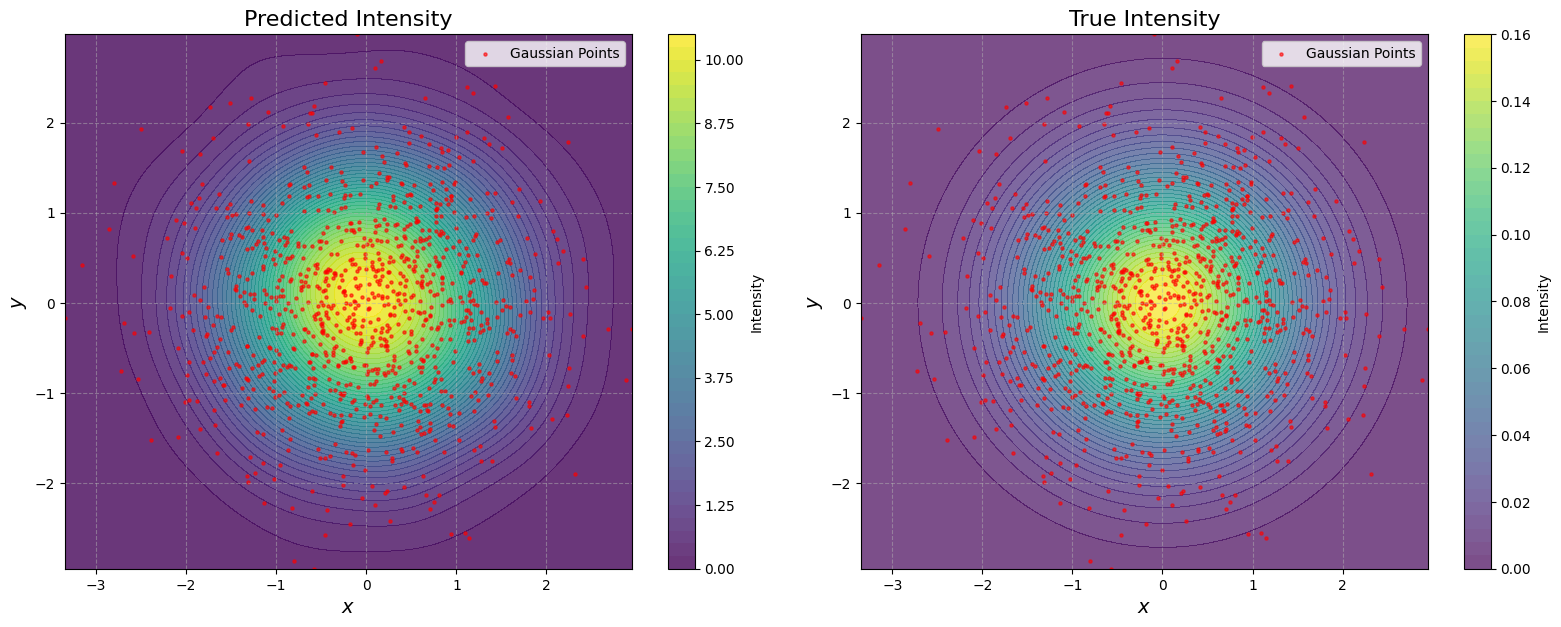

In [41]:

# Extract data
x = X_test[0][:, 0]
y = X_test[0][:, 1]

x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# Generate grid for intensity
x_lin = np.linspace(x_min, x_max, 100)  # Adjust resolution if needed
y_lin = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_lin, y_lin)

# Compute intensity values for the grid
intensity_2d = model(torch.tensor(np.concatenate([xx.flatten()[:, None], yy.flatten()[:, None]], 1), dtype=torch.float32)).reshape(xx.shape)

mu_x, mu_y = np.array(mu)
points = np.stack([xx.ravel() - mu_x, yy.ravel() - mu_y], axis=1)
cov_inv = np.linalg.inv(cov)
quad_form = np.einsum('ij,jk,ik->i', points, cov_inv, points)
lambda_0 = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
intensity_real = lambda_0 * np.exp(-0.5 * quad_form).reshape(xx.shape)

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predicted Intensity
contour1 = ax[0].contourf(xx, yy, (intensity_2d).data.numpy(), levels=50, cmap='viridis', alpha=0.8)
fig.colorbar(contour1, ax=ax[0], label="Intensity")
ax[0].scatter(x, y, c='red', s=5, alpha=0.6, label='Gaussian Points')
ax[0].set_xlabel(r'$x$', fontsize=14)
ax[0].set_ylabel(r'$y$', fontsize=14)
ax[0].set_title(r'Predicted Intensity', fontsize=16)
ax[0].set_aspect('equal')
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].grid(True, linestyle='--', alpha=0.5)
ax[0].legend()

# Plot 2: True Intensity Function
contour2 = ax[1].contourf(xx, yy, intensity_real, levels=50, cmap='viridis', alpha=0.7)
fig.colorbar(contour2, ax=ax[1], label="Intensity")
ax[1].scatter(x, y, c='red', s=5, alpha=0.6, label='Gaussian Points')
ax[1].set_xlabel(r'$x$', fontsize=14)
ax[1].set_ylabel(r'$y$', fontsize=14)
ax[1].set_title('True Intensity', fontsize=16)
ax[1].set_aspect('equal')
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].grid(True, linestyle='--', alpha=0.5)
ax[1].legend()

plt.tight_layout()
plt.show()


In [43]:
mse_list_2d = []
r2_list_2d = []

for batch in tqdm(loader_test, desc="Evaluating Gaussian Process"):
    for x_test in batch[0]:  # Iterate over test points directly
        x_test = x_test.numpy()  # Convert to NumPy array if needed

        mu_x, mu_y = np.asarray(mu, dtype=float) 
        cov_inv = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)

        # Shifted points for real intensity calculation
        points = np.stack([x_test[:, 0] - mu_x, x_test[:, 1] - mu_y], axis=1)
        intensity_real_2d = (
            (1 / (2 * np.pi * np.sqrt(det_cov)))
            * np.exp(-0.5 * np.einsum('ij,jk,ik->i', points, cov_inv, points))
        )

        # Predict intensities using x_test points
        intensity_pred_2d = model(torch.tensor(x_test, dtype=torch.float32)).squeeze().detach().numpy()

        # Normalize intensities
        intensity_pred_2d /= np.max(intensity_pred_2d)
        intensity_real_2d /= np.max(intensity_real_2d)

        # Compute MSE and R-squared
        mse_2d = mean_squared_error(intensity_real_2d, intensity_pred_2d)
        r2_2d = r2_score(intensity_real_2d, intensity_pred_2d)

        mse_list_2d.append(mse_2d)
        r2_list_2d.append(r2_2d)

average_mse_2d = np.mean(mse_list_2d)
average_r2_2d = np.mean(r2_list_2d)

print(f"Average MSE across all test samples (2D): {average_mse_2d}")
print(f"Average R-squared across all test samples (2D): {average_r2_2d}")

Evaluating Gaussian Process: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s]

Average MSE across all test samples (2D): 0.0018726943750493504
Average R-squared across all test samples (2D): 0.9775041682391429
